## Example 5: Extractive Distillation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interactive, Button, VBox, HBox, Output
from IPython.display import clear_output

import src.utils.AntoineEquation as AE
from src.distillation.DistillationDoubleFeed import *

from src.thermo_models.VanLaarModel import *
from src.distillation.residue_curves import *

import pickle
from utils.dictionary_approx import *

In [2]:
# Import fixed points

with open("./src/utils/pickles/demo_3_acetmethwater_r.pkl", "rb") as f:
    demo_3_acetmethwater_r_dict = pickle.load(f)

with open("./src/utils/pickles/demo_4_fr_to_fixed_points_AceMethWaterSys.pkl", "rb") as f:
    demo_4_fr_to_fixed_points_AceMethWaterSys = pickle.load(f)

In [3]:
#Acetone (1 - Light) Methanol (2 - Intermediate) Water (3 - Heavy)
#Table A.6 in Knapp 
A_ij = {
    (1,1):0,
    (1,2):182.0,
    (1,3):795.0,
    (2,1):196,
    (2,2):0,
    (2,3):332.6,
    (3,1):490.0,
    (3,2):163.80,
    (3,3):0
}

#Different definition of Antoine where we have to take the negative of B
Acet_A = 21.3099; Acet_B = 2801.53; Acet_C = -42.875
Meth_A = 23.4832; Meth_B = 3634.01; Meth_C = -33.768
#Assuming P < 2 atm
Water_A = 23.2256; Water_B = 3835.18; Water_C = -45.343

#Knapp Thesis Figure 3.8 uses ln form of Antoine
AcetoneAntoine = AE.AntoineEquationBaseE(Acet_A,Acet_B,Acet_C)
MethanolAntoine = AE.AntoineEquationBaseE(Meth_A, Meth_B, Meth_C)
WaterAntoine = AE.AntoineEquationBaseE(Water_A,Water_B,Water_C)
        
P_sys = 101325
# Specify property method for Acetone Methanol Water system
AceMethWaterSys = VanLaarModel(num_comp = 3, P_sys = P_sys, A_coeff = A_ij, comp_names = ["Acetone","Methanol","Water"], partial_pressure_eqs = [AcetoneAntoine, MethanolAntoine, WaterAntoine])

#### Create distillation models

In [4]:
Fr  = 1
R   = 1
xFL = np.array([0.3, 0.6, 0.1])
xFU = np.array([0.2, 0.1, 0.7])
zF  = (Fr/(1+Fr))*xFU + (1/(1+Fr))*xFL                                #Knapp Equation 5.9
xD  = np.array([0.90, 0.08, 0.02]) 
D_B = ((zF[0] - 0.02) / (xD[0] - zF[0]))                             #Knapp Equation 5.13, set xB[0] = 0.01
xB  = np.array([0.02, (zF[1] - D_B*(xD[1]-zF[1])), (zF[2] - D_B*(xD[2]*zF[2]))])


# Distillation model object
distillation_model = DistillationModelDoubleFeed(thermo_model=AceMethWaterSys, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)

# Residue curve map object
rcm = PhasePortraits(thermo_model=AceMethWaterSys, distil_model = distillation_model)

Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or out-of-bound values.
Integration stopped due to overflow, NaN values, or out-of-bound values.


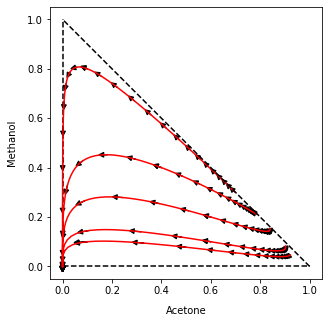

In [5]:
out_residue = Output()
fig, ax = plt.subplots(1,1,figsize= (5,5))
rcm.plot_residue_curve(ax, [0,7],data_points = 100, 
                            init_comps = [ 
                                            np.array([0.4,0.4,0.2]),
                                            np.array([0.6,0.2,0.2]),
                                            np.array([0.6,0.1,0.3]),
                                            np.array([0.1,0.8,0.1]),
                                            np.array([0.1,0.1,0.8])
                                            ])
plt.show()

### Demo 1.5: How do reflux ratio and feed ratio affect feasibility 

Two systems are depicted in the graphs below.  Differences in the locations of the fixed points lead to different properties in the shapes of the operating curves.  These differences are highlighted at 3 sets of feed, distillate and bottoms compositions:

A:  Notice how the middle section correctly acts as a staple that connects the rectifying and stripping sections.  The Middle Vector Field depicts how the curve moves towards a stable node with an enriched Acetone composition.  

B:  Now the Reflux Ratio and Feed Ratio have been changed.  Notice how the Middle Vector Field has changed.  Now the middle section no longer connects the rectifying and stripping sections.  Instead, it moves towards a node which exists outside of the physically realizable triangle of compositions.

C:  **This text is no longer true, not sure if numbers got changed somewhere??**  Focus on the shapes of the Rectifying Sections.  The Acetone-Methanol-Water system is feasible because its rectifying section curves upwards and intersects the staple.  The Ethanol-Water-Ethylene Glycol system has a rectifying section with much fewer equilibrium stages, and it moves directly towards the stable Ethylene Glycol node.  As a result, the column is unfeasible

In [6]:
# Create an interactive plot function
def interactive_plot(system):
    
    dist_model = distillation_model
    rc         = rcm

    if system == 'A':
        middle_start = 2
        dist_model.set_Fr(0.5)
        dist_model.set_r(7)

    elif system == 'B':
        middle_start = 6
        dist_model.set_Fr(1)
        dist_model.set_r(1.5)

    elif system == 'C':
        middle_start = 9
        dist_model.set_Fr(2)
        dist_model.set_r(1)

    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    
    dist_model.plot_rect_strip_comp(axes[0,0], middle_start=middle_start)
    rc.plot_vector_field_rect(axes[0,1]) 
    rc.plot_vector_field_strip(axes[1,0])
    rc.plot_vector_field_middle(axes[1,1])
    
    axes[0,0].set_title('Acetone-Methanol-Water')
    
    plt.tight_layout()
    plt.show()


system_widget = widgets.Dropdown(options=["A", "B", "C"], description='Demo Choice:', disabled=False) 

# Create an interactive plot with the dropdown widget
interactive(interactive_plot,system = system_widget)

interactive(children=(Dropdown(description='Demo Choice:', options=('A', 'B', 'C'), value='A'), Output()), _do…

### Demo 2: How does the location of the solvent feed stage affect feasibility

In [7]:
# Create an interactive plot function
def interactive_plot(middle_start):

    dist_model    = distillation_model
    rc            = rcm
    
    Fr = 0.5
    R = 3
    xFL = np.array([0.3, 0.6, 0.1])
    xFU = np.array([0.2, 0.1, 0.7])
    zF = (Fr/(1+Fr))*xFU + (1/(1+Fr))*xFL                                #Knapp Equation 5.9
    xD = np.array([0.93, 0.04, 0.03]) 
    D_B = ((zF[0] - 0.02) / (xD[0] - zF[0]))                             #Knapp Equation 5.13, set xB[0] = 0.01
    xB = np.array([0.02, (zF[1] - D_B*(xD[1]-zF[1])), (zF[2] - D_B*(xD[2]*zF[2]))])

    dist_model.set_Fr(Fr)
    dist_model.set_r(R)
    dist_model.set_xFL(xFL)
    dist_model.set_xFU(xFU)
    dist_model.set_xD(xD)
    dist_model.set_zF(zF)
    dist_model.set_xB(xB)
     
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    dist_model.plot_rect_strip_comp(ax[0], middle_start=middle_start)
    dist_model.plot_middle_comp(ax[1], middle_start=middle_start)
    rc.plot_vector_field_middle(ax[1])
    
    plt.show()

# Create a dropdown widget for middle_start
middle_start_widget = widgets.Dropdown(options=[2, 4, 6, 8, 10], description='Middle Section Start:', disabled=False)


# Create an interactive plot with the dropdown widget
interactive(interactive_plot, middle_start=middle_start_widget)

interactive(children=(Dropdown(description='Middle Section Start:', options=(2, 4, 6, 8, 10), value=2), Output…

### Demo 3
A maximum reflux ratio exists, around R=60?

In [8]:
R_slider =  widgets.FloatLogSlider(value=1, min=0, max=2, step=0.001,  description='Reflux Ratio:', readout_format='.1f')
go_button = widgets.Button(description='Create Model', width='15%', margin='0 10px 0 0')
system_widget = widgets.Dropdown(
    options=["Acetone/Methanol/Water","Ethanol/Water/Ethylene Glycol"],
    description='Components:',
    disabled=False
    ) 
# Create a dropdown widget for middle_start
middle_start_widget = widgets.Dropdown(
    options=[2, 4, 6, 8, 10],
    description='Middle Section Start:',
    disabled=False
)
out_middle = Output()

def plot_reflux_demo_ex5(R = R_slider, thermo_system = system_widget.value, middle_start=6):
    thermo_choice = AceMethWaterSys
    Fr = 1.0
    if thermo_system == 'Ethanol/Water/Ethylene Glycol':
        #thermo_choice = EthWaterEGSys
        Fr = 0.1
    xFL = np.array([0.3, 0.6, 0.1])
    xFU = np.array([0.2, 0.1, 0.7])
    zF = (Fr/(1+Fr))*xFU + (1/(1+Fr))*xFL                                #Knapp Equation 5.9
    xD = np.array([0.93, 0.04, 0.03]) 
    D_B = ((zF[0] - 0.02) / (xD[0] - zF[0]))                             #Knapp Equation 5.13, set xB[0] = 0.01
    xB = np.array([0.02, (zF[1] - D_B*(xD[1]-zF[1])), (zF[2] - D_B*(xD[2]*zF[2]))])

    distillation_model = DistillationModelDoubleFeed(thermo_model = thermo_choice, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)
    fig, ax = plt.subplots(1,1,figsize= (5,10))
    distillation_model.plot_rect_strip_comp(ax, middle_start=middle_start)
    plt.subplots_adjust(hspace=0)
    plt.show()

def on_go_button_click(b):
    with out_middle:
        clear_output(wait=True)
        plt.close('all')  # Close all open matplotlib plots
        plot_reflux_demo_ex5(R=R_slider.value, thermo_system=system_widget.value, middle_start = middle_start_widget.value)
        
go_button = Button(description='Generate Plot')
go_button.on_click(on_go_button_click)

layout = VBox([system_widget,middle_start_widget, HBox([R_slider, go_button]), out_middle])
display(layout)

### Demo 4
Changing Feed Ratio

In [9]:
Fr_slider =  widgets.FloatLogSlider(value=0.64, min=-1, max=1, step=0.001,  description='Feed Ratio:', readout_format='.2f')
go_button = widgets.Button(description='Create Model', width='15%', margin='0 10px 0 0')
system_widget = widgets.Dropdown(
    options=["Acetone/Methanol/Water","Ethanol/Water/Ethylene Glycol"],
    description='Components:',
    disabled=False
    ) 
# Create a dropdown widget for middle_start
middle_start_widget = widgets.Dropdown(
    options=[2, 4, 6, 8, 10],
    description='Middle Section Start:',
    disabled=False
)
out_middle = Output()

def plot_reflux_demo_ex5_demo4(Fr = Fr_slider, thermo_system = system_widget.value, middle_start=6):
    thermo_choice = AceMethWaterSys
    R = 1.35
    if thermo_system == 'Ethanol/Water/Ethylene Glycol':
        #thermo_choice = EthWaterEGSys
        R = 6
    xFL = np.array([0.3, 0.6, 0.1])
    xFU = np.array([0.2, 0.1, 0.7])
    zF = (Fr/(1+Fr))*xFU + (1/(1+Fr))*xFL                                #Knapp Equation 5.9
    xD = np.array([0.93, 0.04, 0.03]) 
    D_B = ((zF[0] - 0.02) / (xD[0] - zF[0]))                             #Knapp Equation 5.13, set xB[0] = 0.01
    xB = np.array([0.02, (zF[1] - D_B*(xD[1]-zF[1])), (zF[2] - D_B*(xD[2]*zF[2]))])

    distillation_model = DistillationModelDoubleFeed(thermo_model = thermo_choice, Fr = Fr, zF = zF, xFL = xFL, xFU = xFU, xD = xD, xB = xB, reflux = R)
    fig, ax = plt.subplots(1,1,figsize= (5,10))
    distillation_model.plot_rect_strip_comp(ax, middle_start=middle_start)
    plt.subplots_adjust(hspace=0)
    plt.show()


def on_go_button_click(b):
    with out_middle:
        clear_output(wait=True)
        plt.close('all')  # Close all open matplotlib plots
        plot_reflux_demo_ex5_demo4(Fr=Fr_slider.value, thermo_system=system_widget.value, middle_start = middle_start_widget.value)
        
go_button = Button(description='Generate Plot')
go_button.on_click(on_go_button_click)

layout = VBox([system_widget,middle_start_widget, HBox([Fr_slider, go_button]), out_middle])
display(layout)